# Домашнее задание

ML разработчикам необходимо не только уметь обучать нейронные сети и генерировать новые идеи, но еще и уметь в страивать наработки в pipeline. В этом домашнем задании нам предстоит сделать из frustum детектора production ready (ну почти) решение, которое может работать на сырых данных.

К сожалению, frustum-pointnet работает независимо для каждой 2D детекции. В этом домашнем задании вам предстоит написать обертку над frustum-pointnet, которая будет работать над целыми облаками. Вам также нужно будет воспользоваться 2D детектором, чтобы находить коробки на изображении.

Во второй части задания вам нужно будет написать оценку качества работы вашего алгоритма, которая становится чуть сложнее, когда на сцене могут находится много объектов.

## Часть 1

Ниже написан класс, который вам нужно реализовать. Чтобы воспользоваться предобученной сетью, позаимствуйте код из
https://github.com/charlesq34/frustum-pointnets/blob/master/train/test.py

Предобученные модели лежат здесь: https://shapenet.cs.stanford.edu/media/frustum_pointnets_snapshots.zip

В частности, вам нужно модифицировать функцию `get_session_and_ops` - функция должна уметь работать без глобальных флагов. После этого посмотрите, как эта функция используется.
Выход сети преобразуется в понятный формат в функции `write_detection_results`.

In [1]:
! pip3 install "tensorflow==1.14"

Defaulting to user installation because normal site-packages is not writeable


In [1]:
import sys
sys.path.append('frustum_pointnets/kitti')

In [24]:
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib.patches import Rectangle


from collections import namedtuple
import pickle

import cv2
from PIL import Image
from ssd import SSD

import kitti_object
from kitti_object import get_lidar_in_image_fov

In [60]:
Detection = namedtuple('Detection', ['xyz', 'angle', 'lwh', 'confidence'])
Scene = namedtuple('Scene', ['detections'])

class PipelineDetector(object):
    def __init__(self, frustum_pointnet, frustum_batch_size, ssd_detector, ssd_threshold):
        self.frustum_pointnet   = frustum_pointnet
        self.frustum_batch_size = frustum_batch_size
        self.detector = ssd_detector
        self.ssd_threshold = ssd_threshold
    
    def predict(self, xyzi, image, calibration):
        xyz = xyzi[:, :3]
        
        boxes = self._get_detector_boxes(image)
        plt.figure(figsize=(20, 20))
        
        # TODO: process lidar point cloud and construct frustum examples
        
        for box in boxes:
            print(f'box {box}')
            
            points = self.filter_points_in_box(xyz, box, calibration)
            if len(points) == 0:
                continue
            
            plt.scatter(points[:, 0], points[:, 1], c=points[:, 2],  s=0.1)
            plt.xlim(-70, 70)
            plt.ylim(-70, 70)
           
        plt.colorbar()
        plt.show()

        # TODO: run frustum inference (use batch to accelerate inference per frame)
        # TODO: construct Scene namedtuple and return it
        pass
    
    def filter_points_in_box(self, xyz, box, calibration):
        y_min, x_min, y_max, x_max = box
        _, _, fov_idx = get_lidar_in_image_fov(xyz, calibration, 
                                               x_min, y_min, x_max, y_max, 
                                               True)
        return xyz[fov_idx]
    
    def _get_detector_boxes(self, image):
        # run 2D detector on the image
        detections = self.detector.predict(image)
        
        # extract bounding boxes with vehicle classes and filter them by ssd_threshold
        CAR_CLASS = 1
        boxes = detections['detection_boxes']
        n = detections['num_detections']
        car_idx = (detections['detection_classes'] == CAR_CLASS) & (detections['detection_scores'] > self.ssd_threshold)
        car_idx[n:] = False
        
        boxes = boxes[car_idx]
        
        # convert boxes to image coordinates
        H, W, _ = image.shape
    
        res_boxes = []
        for box in boxes:
            y1, x1, y2, x2 = box
            res_boxes.append((y1 * H, 
                              x1 * W, 
                              y2 * H,
                              x2 * W))
        return res_boxes

In [54]:
dataset = kitti_object.kitti_object('kitti_hw_dataset')

In [55]:
def filter_cars(objects):
    return [obj for obj in objects if obj.type in ['Car', 'Van']]

In [ ]:
IMAGE_ID = 7

xyzi        = dataset.get_lidar(IMAGE_ID)
image       = dataset.get_image(IMAGE_ID)
calibration = dataset.get_calibration(IMAGE_ID)

(-70.0, 70.0)

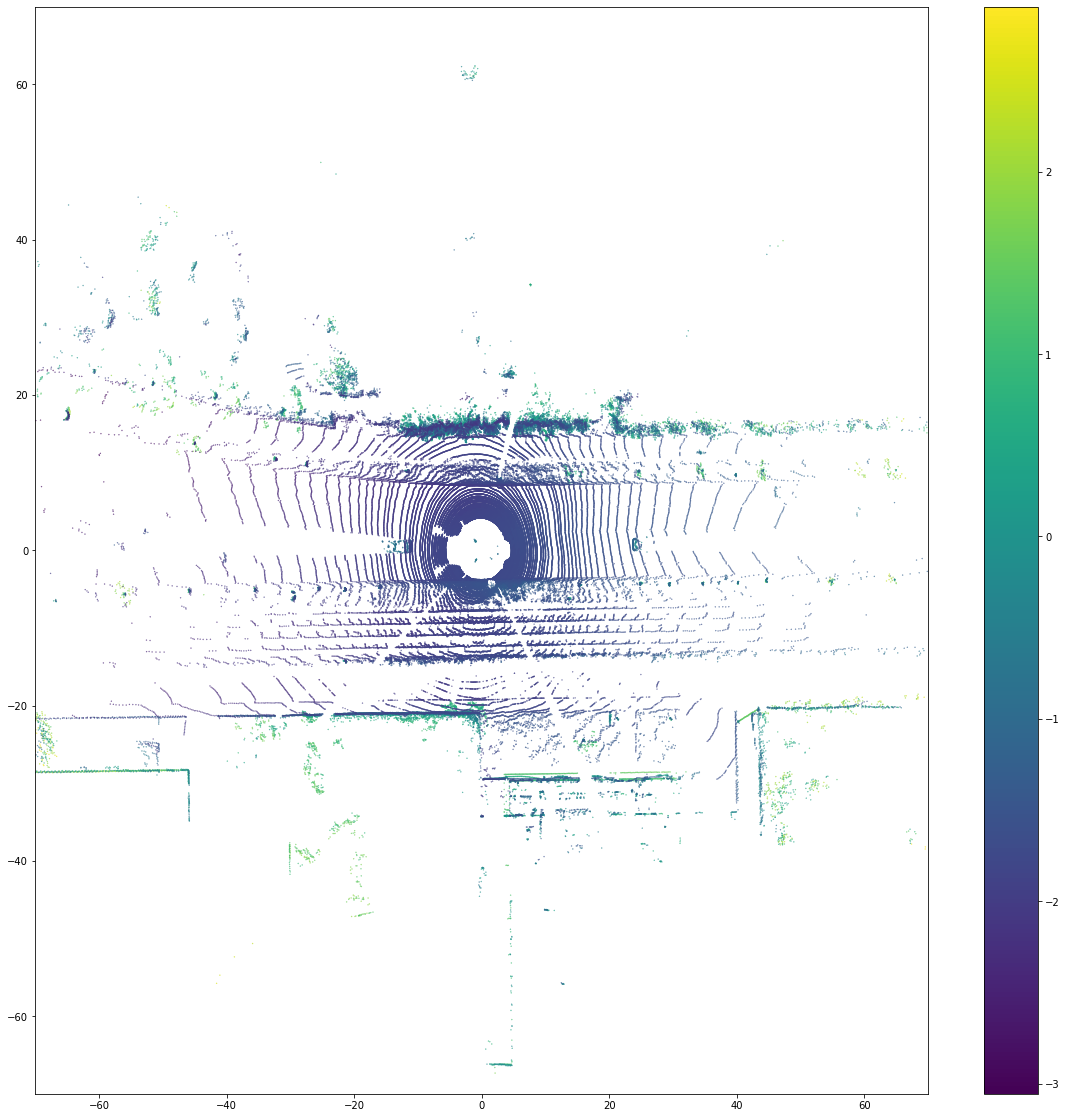

In [63]:
plt.figure(figsize=(20, 20))
plt.scatter(xyzi[:, 0], xyzi[:, 1], c=xyzi[:, 2],  s=0.1)
plt.colorbar()
plt.xlim(-70, 70)
plt.ylim(-70, 70)

In [57]:
ssd = SSD('tmp')

In [58]:
calibration.project_velo_to_image

<bound method Calibration.project_velo_to_image of <kitti_util.Calibration object at 0x7fa3cb27add0>>

box (179.51195687055588, 478.9052438735962, 202.85025984048843, 512.7534722685814)
box (176.20211094617844, 542.3708340525627, 194.420725107193, 566.0404493808746)
box (173.54541644454002, 562.601248562336, 224.27617013454437, 614.3888429403305)


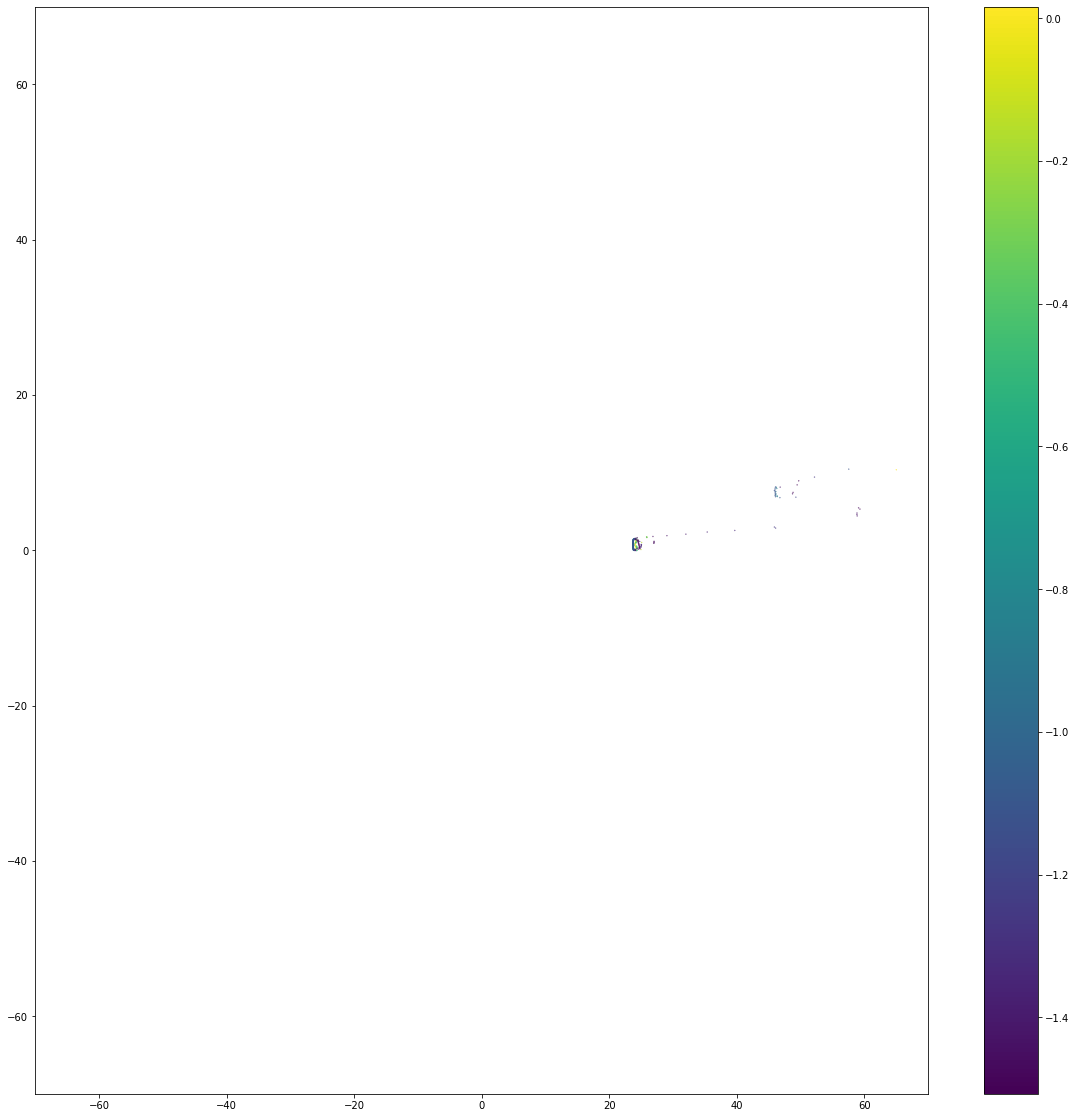

In [61]:
pipeline = PipelineDetector(None, 1, ssd, 0.9)
pipeline.predict(xyzi, image, calibration)

In [3]:
Scene([Detection(None, None, None, None), Detection(None, None, None, None)])

Scene(detections=[Detection(xyz=None, angle=None, lwh=None, confidence=None), Detection(xyz=None, angle=None, lwh=None, confidence=None)])

### 2D детектор

В файле ssd.py есть детектор (файл называется ssd, но на самом деле там faster-rcnn), обученный на kitti. У него можно позвать predict на одном изображении. Коробки возвращаются в нормализованных координатах картинки. Класс 1 соответствует машинам, 2 - пешеходам.

In [5]:
detector = SSD('tmp')

In [3]:
with open('projection_example.npy') as f:
    data_example = pickle.load(file=f)

FileNotFoundError: [Errno 2] No such file or directory: 'projection_example.npy'

In [4]:
data_example

NameError: name 'data_example' is not defined

In [5]:
image = data_example['image']

NameError: name 'data_example' is not defined

In [10]:
detector.predict(image)

{'detection_boxes': array([[0.56678456, 0.42429185, 0.7745029 , 0.46590117],
        [0.55427235, 0.3236863 , 0.77801454, 0.3629127 ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.      

## Часть 2

Для оценки качества работы 3D детекторов обычно используется average precision. Как измерить precision и recall детектора?

У каждой коробки детектора есть confidence. После того, как мы зафиксировали порог, у нас остается часть детекций.
Давайте теперь посмотрим на сцену сверху: bird's eye view. Забудем про координату z.

Далее мы можем посчитать IoU между всеми коробками ground truth и нашими детекциями.Давайте решим, что если IoU больше 0.7, то мы будем считать, что мы увидели gt коробку - относим эту детекцию к TP. Если gt не нашла пару - False Negative. Если детекция не нашла пару - False Positive.

Ваша задача написать код подсчета метрики average precision построенного детектора.

# Kitti Dataset
[Kitti dev-kit](https://s3.eu-central-1.amazonaws.com/avg-kitti/devkit_object.zip) : 
там можно найти описание данных и как преобразовывать данные между системами координат.

Homework KITTI dataset :https://www.icloud.com/iclouddrive/0bxlXWgCRTVvsWXmd-kcEqKqA#kitti_hw_dataset

In [7]:
%pwd

'/home/maxkvant/projects/sdc/hw2'

(-50.0, 50.0)

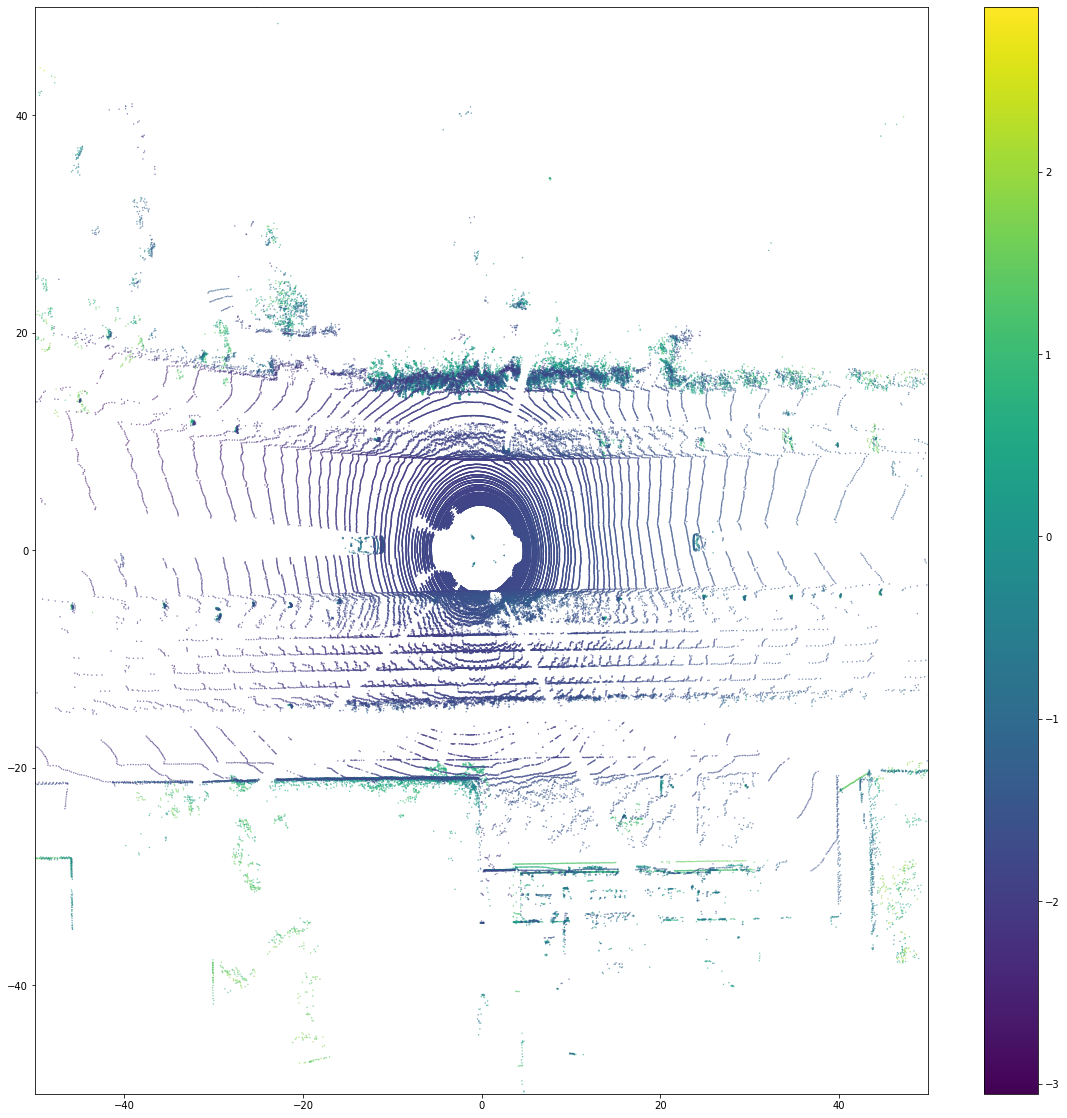

In [84]:
OBJECT_ID = 7

xyzi = kitti_object.get_lidar(OBJECT_ID)

plt.figure(figsize=(20, 20))
plt.scatter(xyzi[:, 0], xyzi[:, 1], c=xyzi[:, 2],  s=0.1)
plt.colorbar()
plt.xlim(-50, 50)
plt.ylim(-50, 50)

In [98]:
xyzi

array([[74.986,  9.638,  2.766,  0.   ],
       [74.286,  9.785,  2.743,  0.   ],
       [73.747,  9.832,  2.725,  0.   ],
       ...,
       [ 3.764, -1.417, -1.759,  0.36 ],
       [ 3.753, -1.399, -1.752,  0.   ],
       [ 3.777, -1.402, -1.763,  0.   ]], dtype=float32)

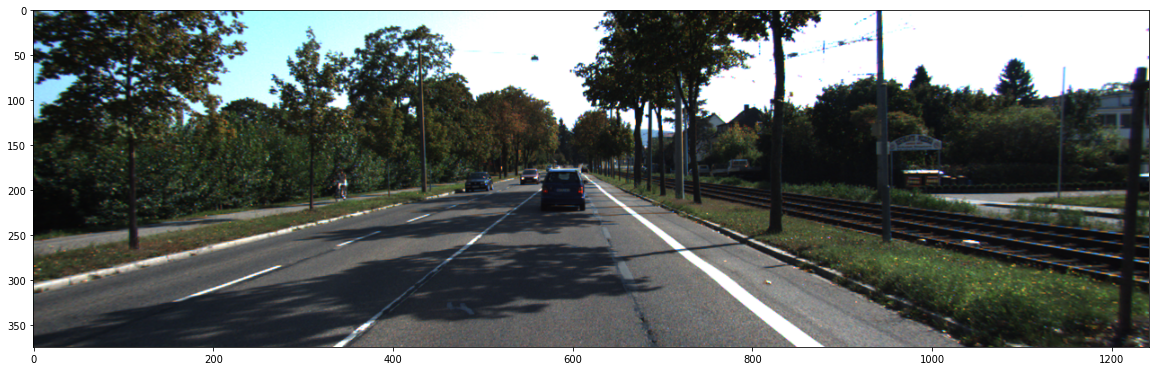

In [56]:
img = kitti_object.get_image(OBJECT_ID)

plt.figure(figsize=(20,20))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [67]:
calibration = kitti_object.get_calibration(OBJECT_ID)

In [91]:
cars = [obj for obj in objects if obj.type=='Car']

In [93]:
[(car.xmin, car.xmax, car.ymin, car.ymax) for car in cars]

[(564.62, 616.43, 174.59, 224.74),
 (481.59, 512.55, 180.09, 202.42),
 (542.05, 565.27, 175.55, 193.79)]

In [69]:
detections = detector.predict(img)
n = detections['num_detections']
detections['detection_boxes'] = detections['detection_boxes'][:n]
detections

{'num_detections': 3,
 'detection_boxes': array([[0.47869855, 0.38559198, 0.540934  , 0.412845  ],
        [0.4698723 , 0.4366915 , 0.51845527, 0.45574915],
        [0.46278778, 0.45298007, 0.5980698 , 0.494677  ]], dtype=float32),
 'detection_scores': array([1.       , 1.       , 0.9999685, 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        

[0.47869855 0.38559198 0.540934   0.412845  ]
478.905 179.512 512.753 202.850
[0.4698723  0.4366915  0.51845527 0.45574915]
542.371 176.202 566.040 194.421
[0.46278778 0.45298007 0.5980698  0.494677  ]
562.601 173.545 614.389 224.276


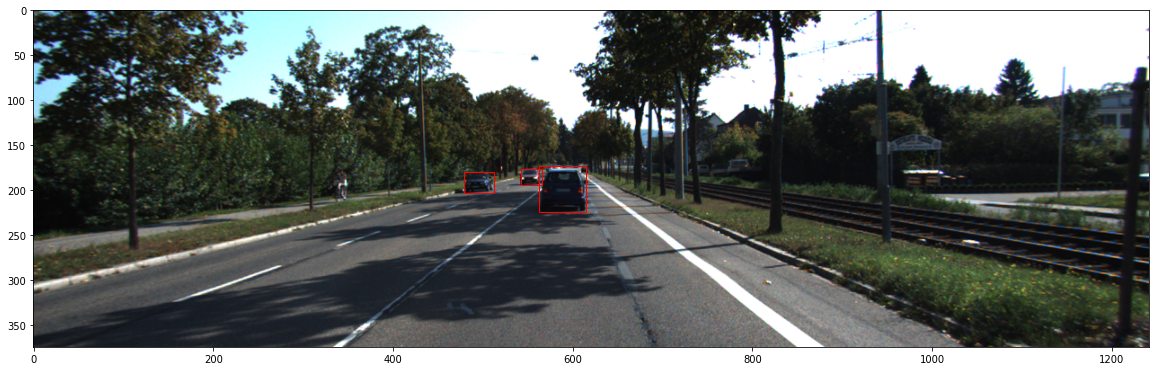

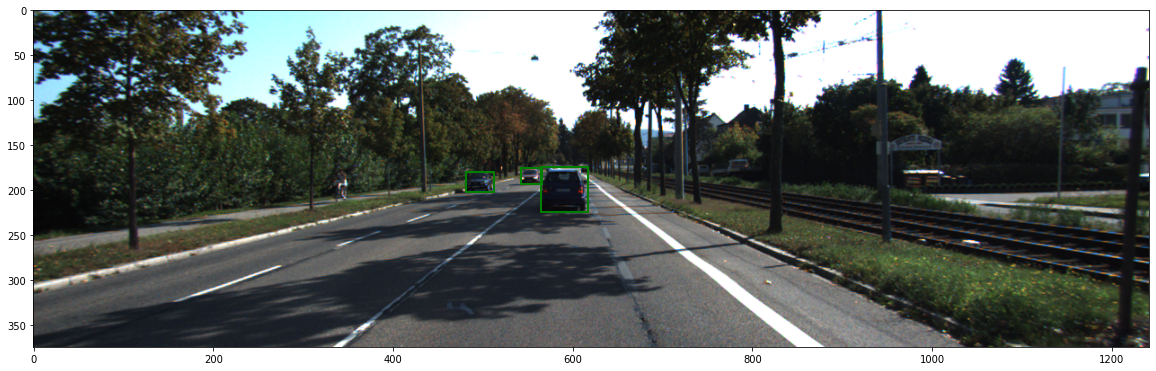

In [97]:
plt.figure(figsize=(20,20))

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

for car in cars:
    plt.gca().add_patch(Rectangle((car.xmin,car.ymin),car.xmax-car.xmin,car.ymax-car.ymin,linewidth=2,edgecolor='g',facecolor='none'))

In [96]:
for car in cars:
    print(car.t)

(-0.69, 1.69, 25.01)
(-7.43, 1.88, 47.55)
(-4.71, 1.71, 60.52)


In [15]:
xyzi = np.fromfile('kitti_hw_dataset/training/velodyne/000100.bin', dtype=np.float32).reshape(-1, 4)

In [16]:
xyzi

array([[43.889,  0.084,  1.693,  0.   ],
       [43.201,  0.218,  1.67 ,  0.   ],
       [42.397,  0.347,  1.643,  0.   ],
       ...,
       [ 3.696, -1.398, -1.726,  0.31 ],
       [ 3.717, -1.399, -1.736,  0.35 ],
       [ 3.724, -1.389, -1.737,  0.   ]], dtype=float32)

(-50.0, 50.0)

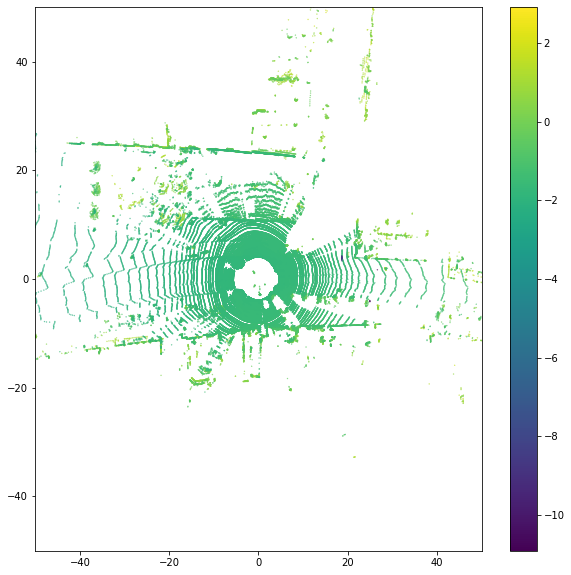

In [9]:
plt.figure(figsize=(10, 10))
plt.scatter(xyzi[:, 0], xyzi[:, 1], c=xyzi[:, 2],  s=0.1)
plt.colorbar()
plt.xlim(-50, 50)
plt.ylim(-50, 50)

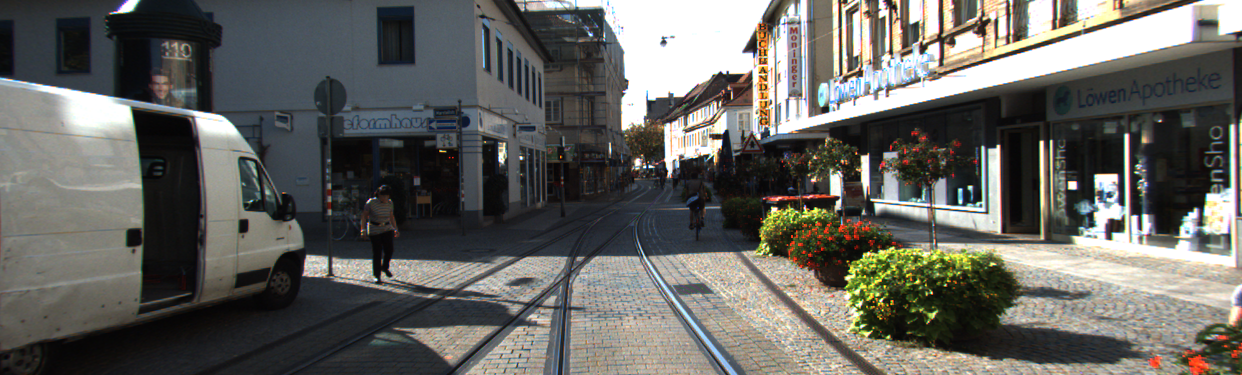

In [11]:
Image.open('kitti_hw_dataset/training/image_2/000100.png')

In [12]:
with open('kitti_hw_dataset/training/calib/000100.txt') as f:
    print(f.read())

P0: 7.215377000000e+02 0.000000000000e+00 6.095593000000e+02 0.000000000000e+00 0.000000000000e+00 7.215377000000e+02 1.728540000000e+02 0.000000000000e+00 0.000000000000e+00 0.000000000000e+00 1.000000000000e+00 0.000000000000e+00
P1: 7.215377000000e+02 0.000000000000e+00 6.095593000000e+02 -3.875744000000e+02 0.000000000000e+00 7.215377000000e+02 1.728540000000e+02 0.000000000000e+00 0.000000000000e+00 0.000000000000e+00 1.000000000000e+00 0.000000000000e+00
P2: 7.215377000000e+02 0.000000000000e+00 6.095593000000e+02 4.485728000000e+01 0.000000000000e+00 7.215377000000e+02 1.728540000000e+02 2.163791000000e-01 0.000000000000e+00 0.000000000000e+00 1.000000000000e+00 2.745884000000e-03
P3: 7.215377000000e+02 0.000000000000e+00 6.095593000000e+02 -3.395242000000e+02 0.000000000000e+00 7.215377000000e+02 1.728540000000e+02 2.199936000000e+00 0.000000000000e+00 0.000000000000e+00 1.000000000000e+00 2.729905000000e-03
R0_rect: 9.999239000000e-01 9.837760000000e-03 -7.445048000000e-03 -9.

In [13]:
with open('kitti_hw_dataset/training/label_2/000100.txt') as f:
    print(f.read())

Van 0.63 0 -0.90 0.00 58.65 320.90 374.00 2.46 2.03 5.35 -5.18 1.69 7.24 -1.51
Cyclist 0.00 0 -1.58 684.31 165.66 710.23 242.31 1.82 0.59 1.89 2.13 1.66 18.06 -1.47
Pedestrian 0.00 0 0.84 359.32 182.26 400.32 285.85 1.57 0.52 0.62 -3.63 1.72 11.35 0.54
Car 0.00 2 -2.46 19.88 179.87 206.64 238.00 1.44 1.62 3.91 -13.04 1.64 18.98 -3.05
DontCare -1 -1 -10 650.19 158.35 666.90 192.77 -1 -1 -1 -1000 -1000 -1000 -10

